### test on two samples from same distr

#### Here's a small guideline through the method I expect to use. 

#### The test is prepared on lognormal distributition with 99.99tile = 8995 and 99.999tile = 15942, which is pretty close to what we have on Cassandra. 

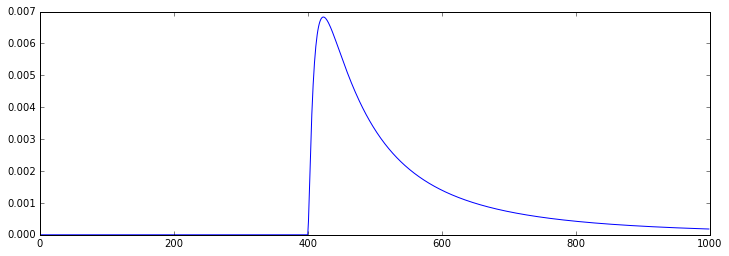

In [250]:
plotDensity([
        distr_0.pdf(np.linspace(0,1000,1000)),
        ])

#### Create two samples from this distribution, which should be marked as the same by our test. Samples sizes are 4000000 each, which is the the same with 10 min Cassandra runs with 10k thpt. 

In [109]:
base_sample = modelDistr.rvs(sample_size)
check_sample = modelDistr.rvs(sample_size)

In [185]:
base_density = densityFromSample(base_sample)[0]

#### First step is to create and smooth density from the first sample

In [186]:
base_density_smoothed = flattenDensities(base_density, bw=10)[0]

Type changing...


#### Than check percentile values

In [252]:
perc_set = [50, 90, 99, 99.9, 99.99, 99.999]

for p in perc_set:
    print "{0} : ".format(p)
    print "base_sample                    : {0}".format(np.percentile(base_sample, p,))
    print "check_sample                   : {0}".format(np.percentile(check_sample, p, ))
    print "smoothed density of base sample: {0}".format(pdfPercentiles(base_density_smoothed, p))

    print "---------------"

50 : 
base_sample                    : 500.038952833
check_sample                   : 499.956309679
smoothed density of base sample: 500
---------------
90 : 
base_sample                    : 865.246266457
check_sample                   : 865.486882388
smoothed density of base sample: 865
---------------
99 : 
base_sample                    : 2030.69236159
check_sample                   : 2027.15755958
smoothed density of base sample: 2031
---------------
99.9 : 
base_sample                    : 4488.32636528
check_sample                   : 4469.64682472
smoothed density of base sample: 4488
---------------
99.99 : 
base_sample                    : 9078.03708198
check_sample                   : 8990.96505124
smoothed density of base sample: 9080
---------------
99.999 : 
base_sample                    : 17282.8895817
check_sample                   : 16724.2083176
smoothed density of base sample: 17284
---------------


#### Difference like we have on Cassandra can be found on the 99.999tile, so the test will be performed with it

To check if the second sample(check_sample) is drawn from the same pdf by the percentle value, I perform Neyman-Pearson test. 
Step-by-step it looks like this:

1. The base hypothesis is that check sample is drawn from the same density function as base sample, which is smoothed density of base sample.
2. Create a set of alternative hypothesises. Here I'm working with alternatives that the check sample is drawn from the distribution shifted right or left, by 1% of maximum value in the base sample. It's quite reasonable alternative for 99.999tile value. 
3. Generate more samples the same size as the original one from the base distribution and alternatives
4. Calculate 99.999 percentile distributions along the base distr and alternatives
5. The statistic to make a decision is the ratio of likelihoods. Let the 99.999tile value of check sample be $ p $, this means our dicision statistic will be $ L_0(p)/L_{\infty}(p) $, where $ L_0(p) $ stands for likelihood of being drawn from base distr and $ L_{\infty}(p) $ for alternative
6. Then we generate more samples from our base distribution and alternative, and for each of them we calculate the percentile value and than decision statistic, so we have the distribution of decision statistic when the base hypothesis is true and when the alternative is true
8. We set the dicision border for decision statistic, means if it's higher than boarder, we believe in basic hypothesis, if lower in alternative. The way to set it depends on the values of false positives and false negatives that we are ready to see.
7. Finaly we take the check sample 99.999tile value and calculate statistic for it, and make a decision.

Here it is:

In [338]:
from scipy.stats import rv_continuous

class Distr(rv_continuous):
    def __init__(self, pdf):
        self.__pdf = pdf
        
    def _pdf(self, x):
        if x < len(self.__pdf) and x > 0:
            return self.__pdf(round(x))
        else:
            return 0
    
    def _rvs(self, size = 1):
        return np.random.choice(range(len(self.__pdf)), size, p = self.__pdf)
        
    def rvs(self, size = 1):
        return self._rvs(size)
    


In [339]:
base_distr = Distr(base_density_smoothed)

#### Here I create alternatives low_density and high_density

In [233]:
shift = 0.01
shift_absolute = int(round(shift * len(base_density_smoothed)))
print shift_absolute

low_density = base_density_smoothed[shift_absolute:]
high_density = np.hstack((np.zeros(shift_absolute), base_density_smoothed))

1206


In [340]:
low_distr = Distr(low_density)
high_distr = Distr(high_density)

####  This is how the 99.999tile value is disterbed. Blue is for base distribution, green is for higher alternative.

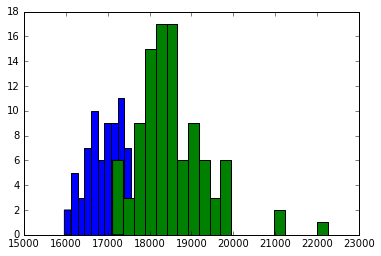

In [235]:
s_base, s_high, np_base, np_high = singleNPDistr(base_distr, high_distr,
                                            lambda x: np.percentile(x, 99.999), sample_size = 4000000)

In [247]:
s_base, s_high, np_base, np_high = singleNPDistr(base_distr, high_distr,
                                            lambda x: np.percentile(x, 99.999), sample_size = 4000000,
                                                np_bootstrap_size = 1000,
                                                stat_sample_0 = s_base, stat_sample_inf = s_high)

#### And this is how decision statistic is disterbed. Blue again is when base hypothesis is true, and green for alternative.

[]

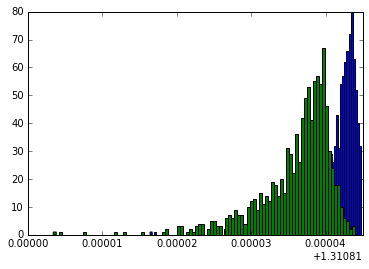

In [255]:
plt.hist(np_base, bins= 100)
plt.hist(np_high, bins = 100)
plt.plot()

In [310]:
all_base = []
all_alt = []
x = []

base_hist = np.histogram(np_base, bins = 100, density=True)
alt_hist = np.histogram(np_high, bins = 100, density = True)

i = 0
j = 0 

while i < len(base_hist[1]) - 2 or j < len(alt_hist[1]) - 2: 
    x.append(min(base_hist[1][i], alt_hist[1][j]))
    all_base.append(base_hist[0][i])
    all_alt.append(alt_hist[0][j])
    if base_hist[1][i + 1] < alt_hist[1][j+1] or j >= len(alt_hist[1]) - 2:
        i += 1
    else:
        j += 1  

In [314]:
false_positive_prop = []
false_negative_prop = []
i = 0
j = 0 

curr_FP = 1
curr_FN = 0

for i in range(1,len(x)):
    false_positive_prop.append(curr_FP)
    false_negative_prop.append(curr_FN)
    
    curr_FP -= all_alt[i] * (x[i] - x[i - 1])
    curr_FN += all_base[i] * (x[i] - x[i - 1 ])

## Here is the main thing! 

#### This plot shows how the False Negative error (FN) of decision based on 99.999 percentile depends on False Positive error(FP). In fact we need to minimize both.
#### For example if we want FN be less than 10% we will get FP about 30%.  This shows that 99.999tile based decision on this sample size is useless, also for real cassandra data even 99.99 is probably useless too. 

#### Possible solution is to increase the sample size. I can find the sample size which will reduce the FP and FN to better values.

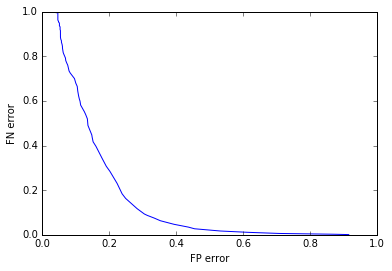

In [322]:
plt.plot(false_negative_prop, false_positive_prop)
plt.ylabel('FN error')
plt.xlabel('FP error')